## Which Classes Consistently Fill?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir(os.path.dirname(os.getcwd()))

In [13]:
df = pd.read_excel("data/df_grad_filtered.xlsx")


## In-Person vs Online Courses by Average Fill Rate

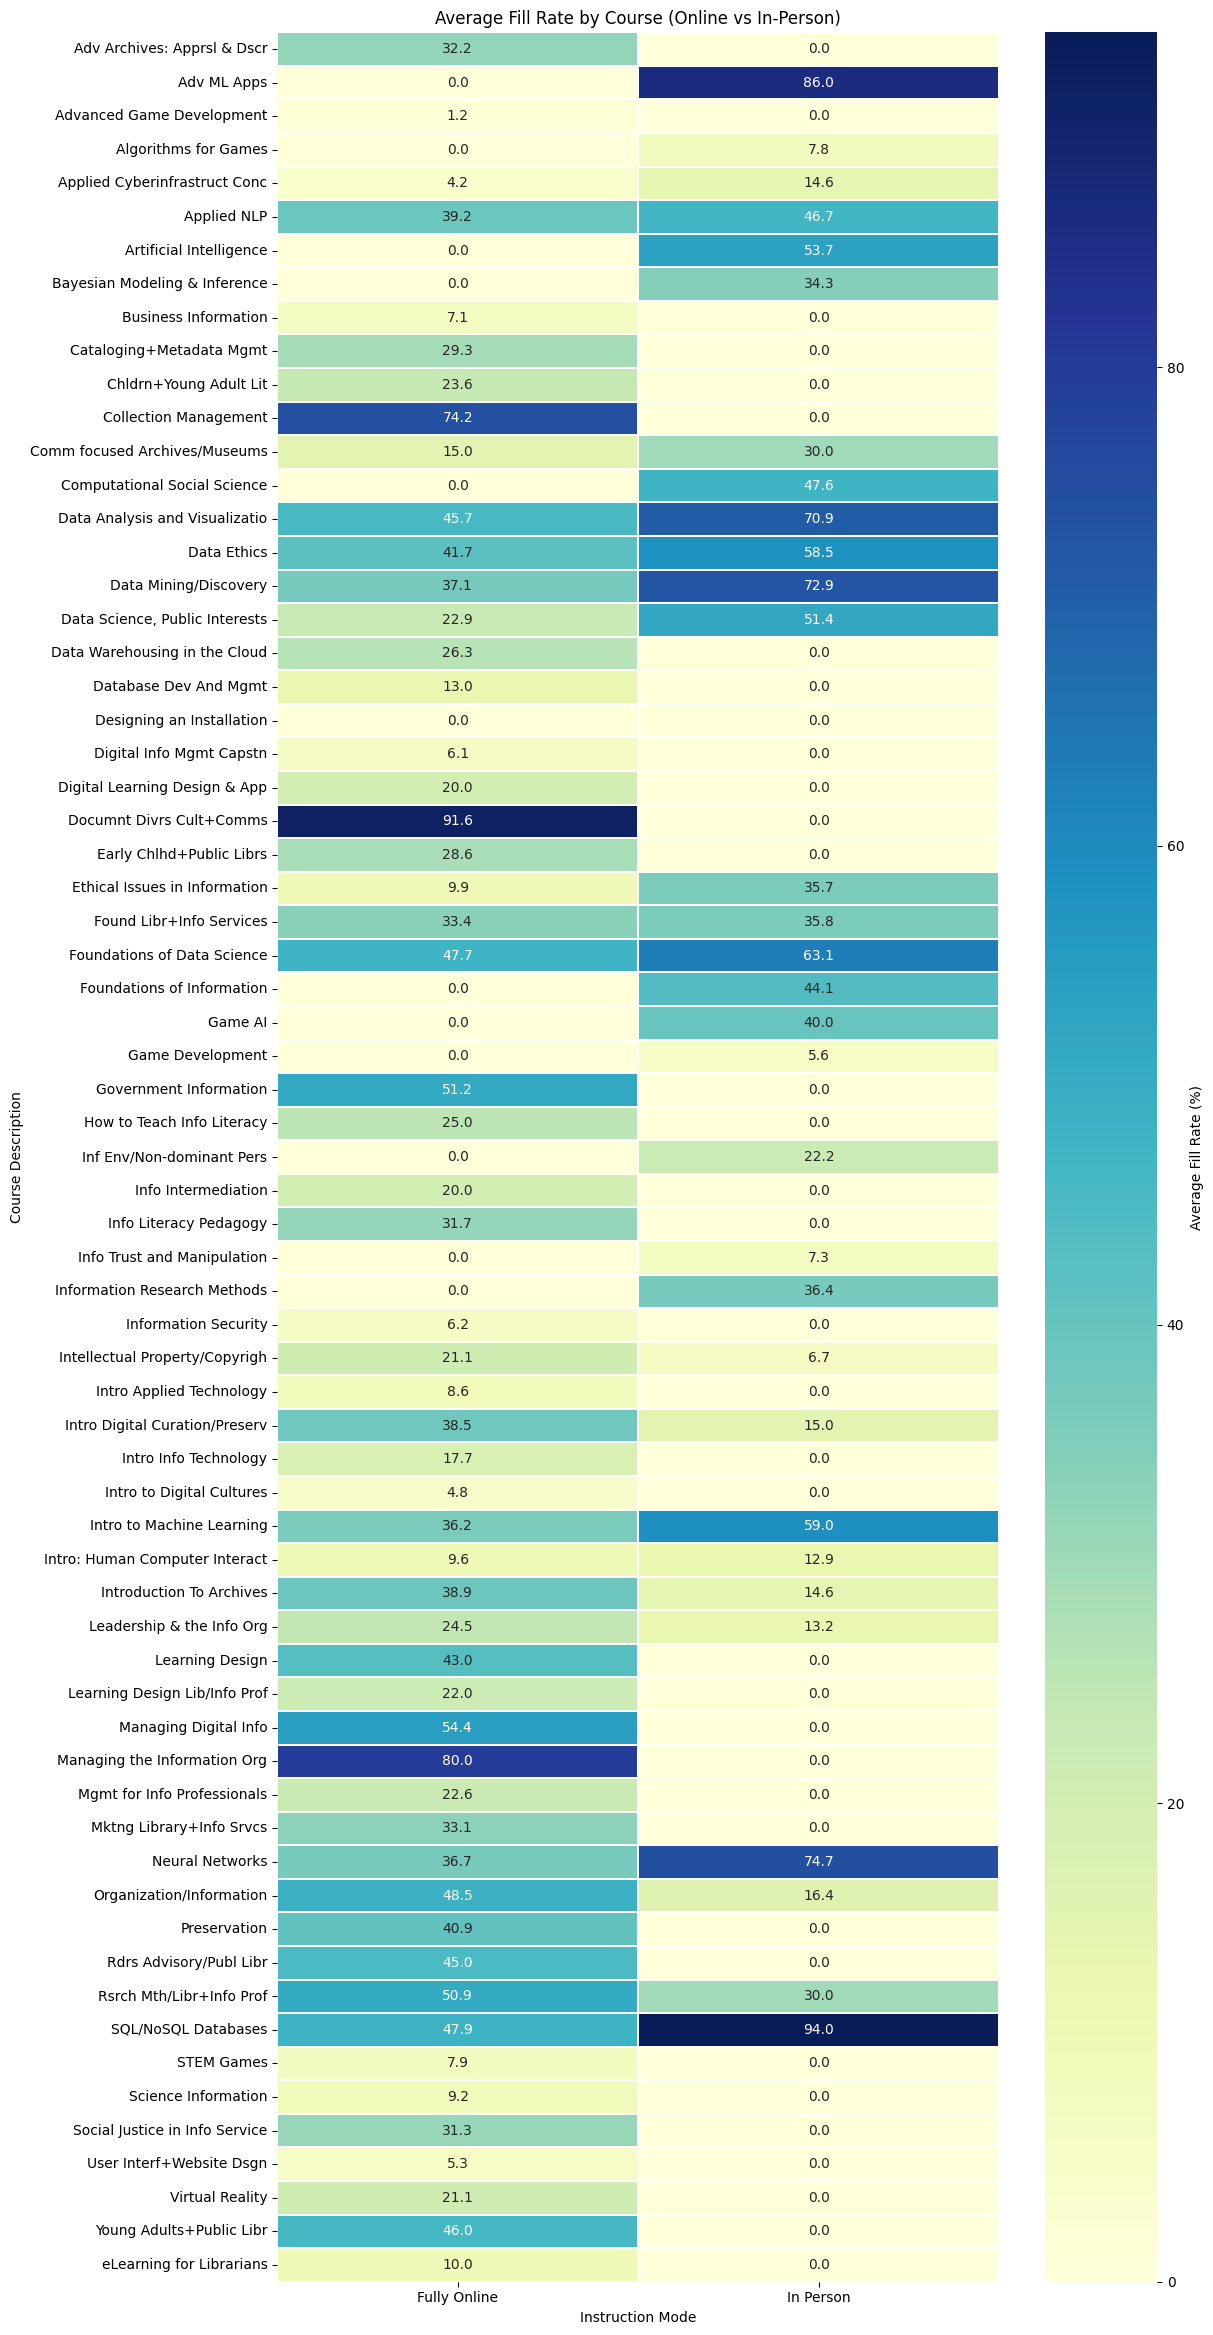

In [26]:
# Filter valid entries and calculate fill rate
df_filtered = df[df['Enrollment Capacity'] > 0].copy()
df_filtered['Fill Rate'] = (df_filtered['Total Enroll'] / df_filtered['Enrollment Capacity']) * 100

# Keep only 'Fully Online' and 'In Person' exactly
valid_modes = ['Fully Online', 'In Person']
df_filtered = df_filtered[df_filtered['Instruction Mode'].isin(valid_modes)]

# Group by Course + Instruction Mode
fill_summary = df_filtered.groupby(['Course Description', 'Instruction Mode']).agg(
    Avg_Fill_Rate=('Fill Rate', 'mean')
).reset_index()

# Pivot for heatmap
heatmap_data = fill_summary.pivot(
    index='Course Description',
    columns='Instruction Mode',
    values='Avg_Fill_Rate'
).fillna(0)

# Plot heatmap
plt.figure(figsize=(12, len(heatmap_data) * 0.35))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.3, cbar_kws={'label': 'Average Fill Rate (%)'})
plt.title("Average Fill Rate by Course (Online vs In-Person)")
plt.xlabel("Instruction Mode")
plt.ylabel("Course Description")
plt.tight_layout()
plt.show()


**Outcome:**  

- Shows how full each course is on average in online vs. in-person formats.

- Many core and technical courses have higher fill rates in online mode.

- Some lab-based or hands-on courses are better filled in person.

- A few courses show very low or no enrollment in one of the formats.

- Courses like Databases have high fill rates in both formats, showing strong demand.

- Helps identify which courses may need More sections, Format changes, Better scheduling.


## Course Offerings and Fill Rates by Time of Day

C:\Users\ramte\AppData\Local\Temp\ipykernel_33360\2106163597.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Meeting Time Start'] = pd.to_datetime(df['Meeting Time Start'], errors='coerce')


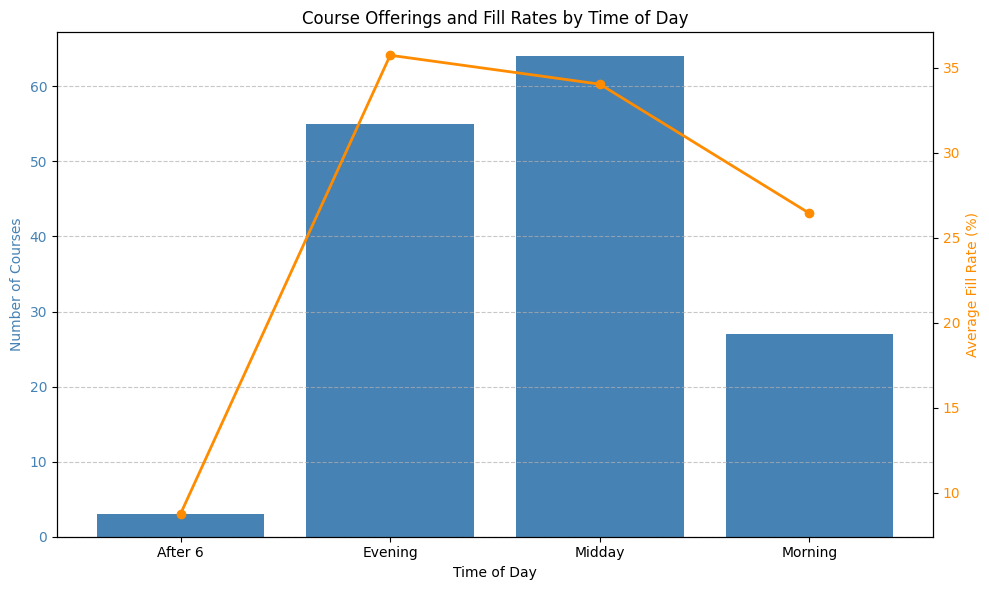

In [ ]:
# Read and process Meeting Time Start
df['Meeting Time Start'] = pd.to_datetime(df['Meeting Time Start'], errors='coerce')
df['Hour'] = df['Meeting Time Start'].dt.hour

# Filter out invalid or online classes (Hour == 0), and valid capacities
df_time_filtered = df[(df['Hour'] != 0) & (df['Enrollment Capacity'] > 0)].copy()
df_time_filtered['Fill Rate'] = (df_time_filtered['Total Enroll'] / df_time_filtered['Enrollment Capacity']) * 100
df_time_filtered['Filled'] = df_time_filtered['Fill Rate'] >= 100

# Assign time-of-day slots
def revised_time_bucket(hour):
    if pd.isna(hour):
        return 'Unknown'
    elif hour < 9:
        return 'Before 9'
    elif hour < 12:
        return 'Morning'
    elif hour < 15:
        return 'Midday'
    elif hour < 18:
        return 'Evening'
    else:
        return 'After 6'

df_time_filtered['Revised Time Slot'] = df_time_filtered['Hour'].apply(revised_time_bucket)

# Summarize by time slot (count all course rows and calculate average fill rate)
summary_by_time_all_courses = df_time_filtered.groupby('Revised Time Slot').agg(
    Number_of_Courses=('Course Description', 'count'),
    Avg_Fill_Rate=('Fill Rate', 'mean')
).reset_index()

# Plot - Bar for number of courses, line for average fill rate
x = summary_by_time_all_courses['Revised Time Slot']
course_counts = summary_by_time_all_courses['Number_of_Courses']
fill_rates = summary_by_time_all_courses['Avg_Fill_Rate']

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot
bars = ax1.bar(x, course_counts, color='steelblue', label='Number of Courses')
ax1.set_xlabel('Time of Day')
ax1.set_ylabel('Number of Courses', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

# Line plot on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(x, fill_rates, color='darkorange', marker='o', linewidth=2, label='Avg Fill Rate (%)')
ax2.set_ylabel('Average Fill Rate (%)', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

# Final styling
plt.title('Course Offerings and Fill Rates by Time of Day')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout()
plt.show()


**Outcome:**  
This chart compares the **number of courses offered** and their **average fill rates** across different times of day.

- **Midday and Evening** slots have the highest number of course offerings, suggesting these are the most preferred scheduling times for instructors and departments.
- Despite fewer offerings in the **Evening**, it shows the **highest average fill rate**, indicating strong student interest or demand during this time.
- **Midday** courses are also popular with a slightly lower average fill rate but the most offerings overall.
- **Morning** classes have lower enrollments and fewer offerings, while **After 6 PM** shows the **lowest number of courses and the lowest fill rate**, indicating limited demand and interest.

This analysis suggests that Evening and Midday time slots strike the best balance between availability and student preference.


### Top 10 courses fill rate based on timings

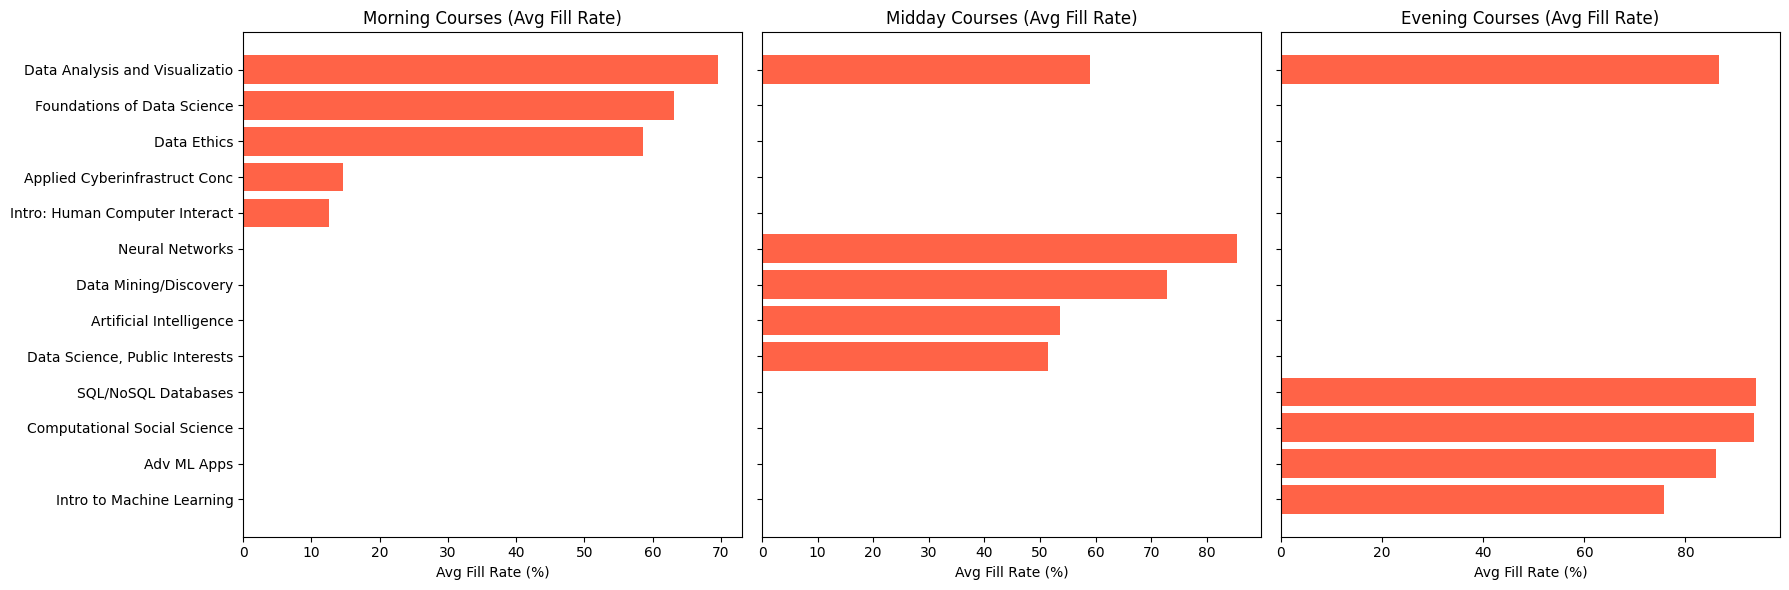

In [16]:
#Group by course and time slot
fill_by_revised_slot = df_time_filtered.groupby(['Course Description', 'Revised Time Slot']).agg(
    Avg_Fill_Rate=('Fill Rate', 'mean'),
    Times_Offered=('Fill Rate', 'count'),
    Times_Full=('Filled', 'sum')
).reset_index()

#Focus on Morning, Midday, Evening only
target_slots = ['Morning', 'Midday', 'Evening']
top_by_revised_slot = {
    slot: fill_by_revised_slot[fill_by_revised_slot['Revised Time Slot'] == slot]
    .sort_values(by='Avg_Fill_Rate', ascending=False).head(5)
    for slot in target_slots
}

#Plot subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, slot in zip(axes, target_slots):
    data = top_by_revised_slot[slot]
    ax.barh(data['Course Description'], data['Avg_Fill_Rate'], color='tomato')
    ax.set_title(f'{slot} Courses (Avg Fill Rate)')
    ax.set_xlabel('Avg Fill Rate (%)')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

**Outcome:**  
This visualization compares **average fill rates** of courses taught in the **Morning, Midday, and Evening** slots.

- **Evening courses** had the **highest fill rates overall**, with multiple courses like **SQL/NoSQL Databases**, **Computational Social Science**, and **Advanced ML Applications** nearing or exceeding 90%. This reinforces the high demand for evening classes, especially for technical topics.

- **Midday courses** also performed well, especially **Neural Networks** and **Data Mining/Discovery**, both showing strong enrollment. While more courses are scheduled at this time, fill rates are slightly lower than in the evening.

- **Morning courses** had the **lowest fill rates** on average. Only a few, such as **Data Analysis and Visualization** and **Foundations of Data Science**, showed notable demand. Others like **Applied Cyberinfrastructure** and **Human-Computer Interaction** had limited engagement.

This pattern indicates that **technical and data-focused courses tend to perform better in later time slots**, especially in the evening, possibly due to greater flexibility or student availability.


## Fill Rates by Scheduled Class Days (MW vs TR)


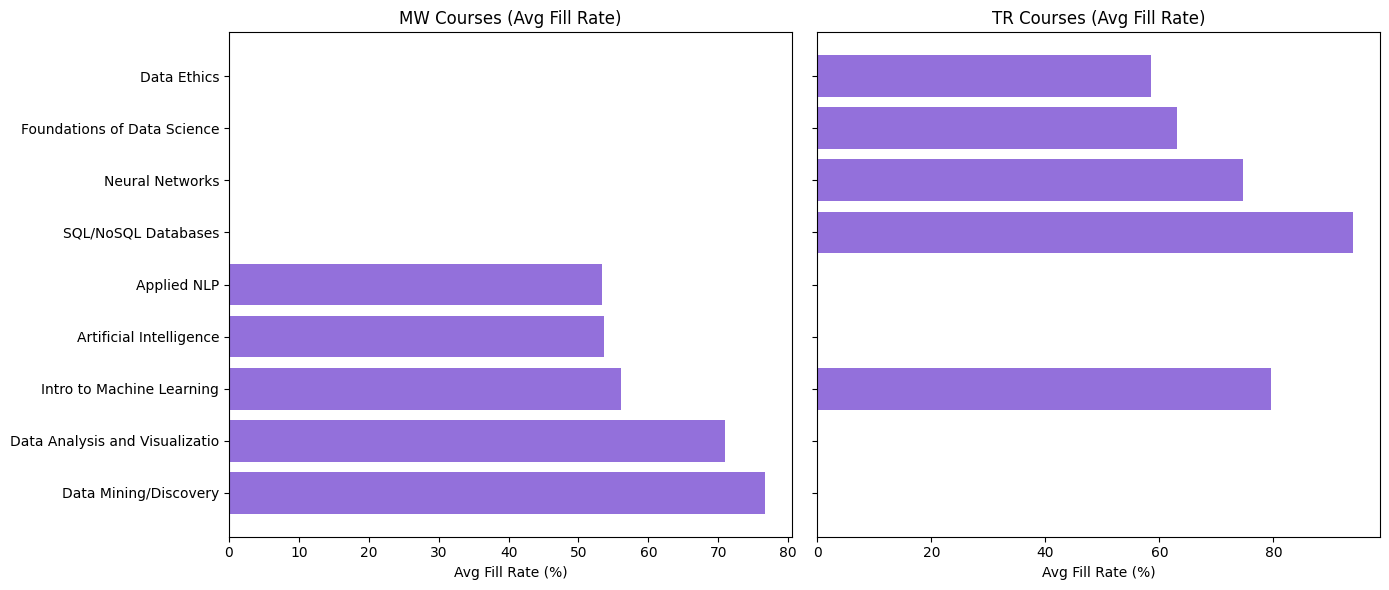

In [ ]:


# Filter out rows with valid capacity
df_days = df[df['Enrollment Capacity'] > 0].copy()

# Calculate fill rate
df_days['Fill Rate'] = (df_days['Total Enroll'] / df_days['Enrollment Capacity']) * 100
df_days['Filled'] = df_days['Fill Rate'] >= 100

# Group by Course and Meeting Days
fill_by_days = df_days.groupby(['Course Description', 'Meeting Days']).agg(
    Avg_Fill_Rate=('Fill Rate', 'mean'),
    Times_Offered=('Fill Rate', 'count'),
    Times_Full=('Filled', 'sum')
).reset_index()

# Focus on MW and TR patterns
common_days = ['MW', 'TR']
top_by_days = {
    day: fill_by_days[fill_by_days['Meeting Days'] == day]
    .sort_values(by='Avg_Fill_Rate', ascending=False).head(5)
    for day in common_days
}

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, day in zip(axes, common_days):
    data = top_by_days[day]
    ax.barh(data['Course Description'], data['Avg_Fill_Rate'], color='mediumpurple')
    ax.set_title(f'{day} Courses (Avg Fill Rate)')
    ax.set_xlabel('Avg Fill Rate (%)')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()


**Outcome:**  
Courses were grouped by their scheduled meeting days — **MW (Monday/Wednesday)** and **TR (Tuesday/Thursday)** — and evaluated based on their average fill rates.

**MW Courses (Monday/Wednesday):**  
- **Data Mining/Discovery** (77%) and **Data Analysis and Visualization** (71%) lead with strong average fill rates.  
- Other well-enrolled courses include **Intro to Machine Learning**, **Artificial Intelligence**, and **Applied NLP**.

**TR Courses (Tuesday/Thursday):**  
- **SQL/NoSQL Databases** stands out with a **93% fill rate**, the highest overall.  
- Other strong performers include **Neural Networks**, **Foundations of Data Science**, and **Intro to Machine Learning**.

**Key Insight:**  
Courses scheduled on **TR days generally show higher average fill rates** than MW, particularly for data science and machine learning-related topics — indicating higher student preference or demand for TR scheduling in technical subjects.


## Fill Trends by Semester (Fall vs Spring)

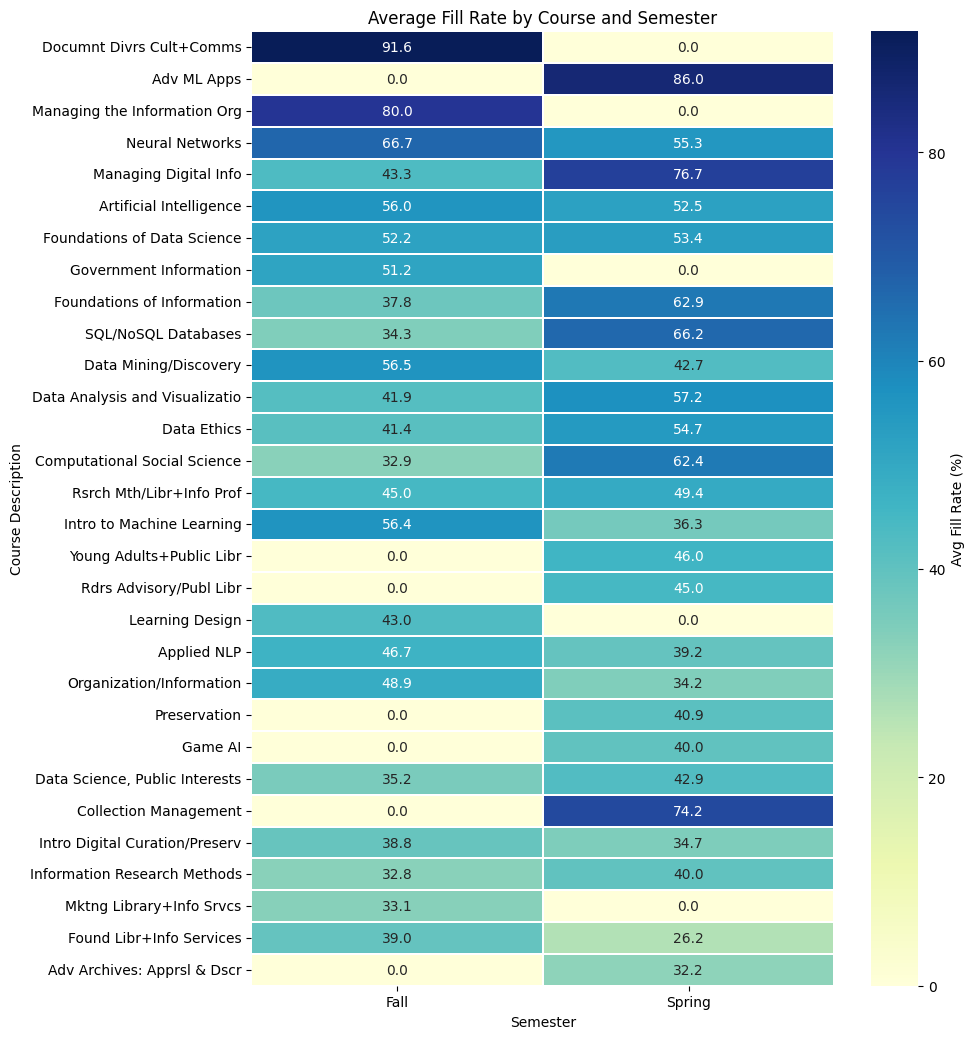

In [27]:
# Prepare the pivot table for heatmap
pivot_semester = fill_by_semester.pivot(
    index='Course Description',
    columns='Semester',
    values='Avg_Fill_Rate'
).fillna(0)  # Fill missing semesters with 0 for clean visuals

# Optional: Limit to top 30 courses by overall average fill rate
top_courses = (
    fill_by_semester.groupby('Course Description')['Avg_Fill_Rate']
    .mean()
    .sort_values(ascending=False)
    .head(30)
    .index
)

pivot_semester = pivot_semester.loc[top_courses]

# Plot heatmap
plt.figure(figsize=(10, len(pivot_semester) * 0.35))
sns.heatmap(pivot_semester, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.3, cbar_kws={'label': 'Avg Fill Rate (%)'})
plt.title("Average Fill Rate by Course and Semester")
plt.xlabel("Semester")
plt.ylabel("Course Description")
plt.tight_layout()
plt.show()


**Outcome:**  
This chart compares the **average fill rates** of popular graduate courses across **Fall** and **Spring** semesters.

- **Spring courses** generally show **higher average fill rates** than those in Fall, indicating stronger student engagement or better alignment with Spring scheduling.
- Courses like **Documenting Diverse Cultures & Communications**, **Managing the Information Organization**, and **Advanced ML Applications** consistently attract strong enrollment in both semesters.
- Technical courses such as **Neural Networks**, **Data Mining/Discovery**, and **Intro to Machine Learning** maintain healthy fill rates year-round.
- **Fall semester** still supports high-demand courses, particularly those with strong academic or programmatic relevance, though their fill rates are slightly lower on average compared to Spring.

This trend suggests students may be more active in course selection during Spring, or institutions may offer more targeted or desirable courses in that term.


## Which Classes Consistently Fill (By Year)

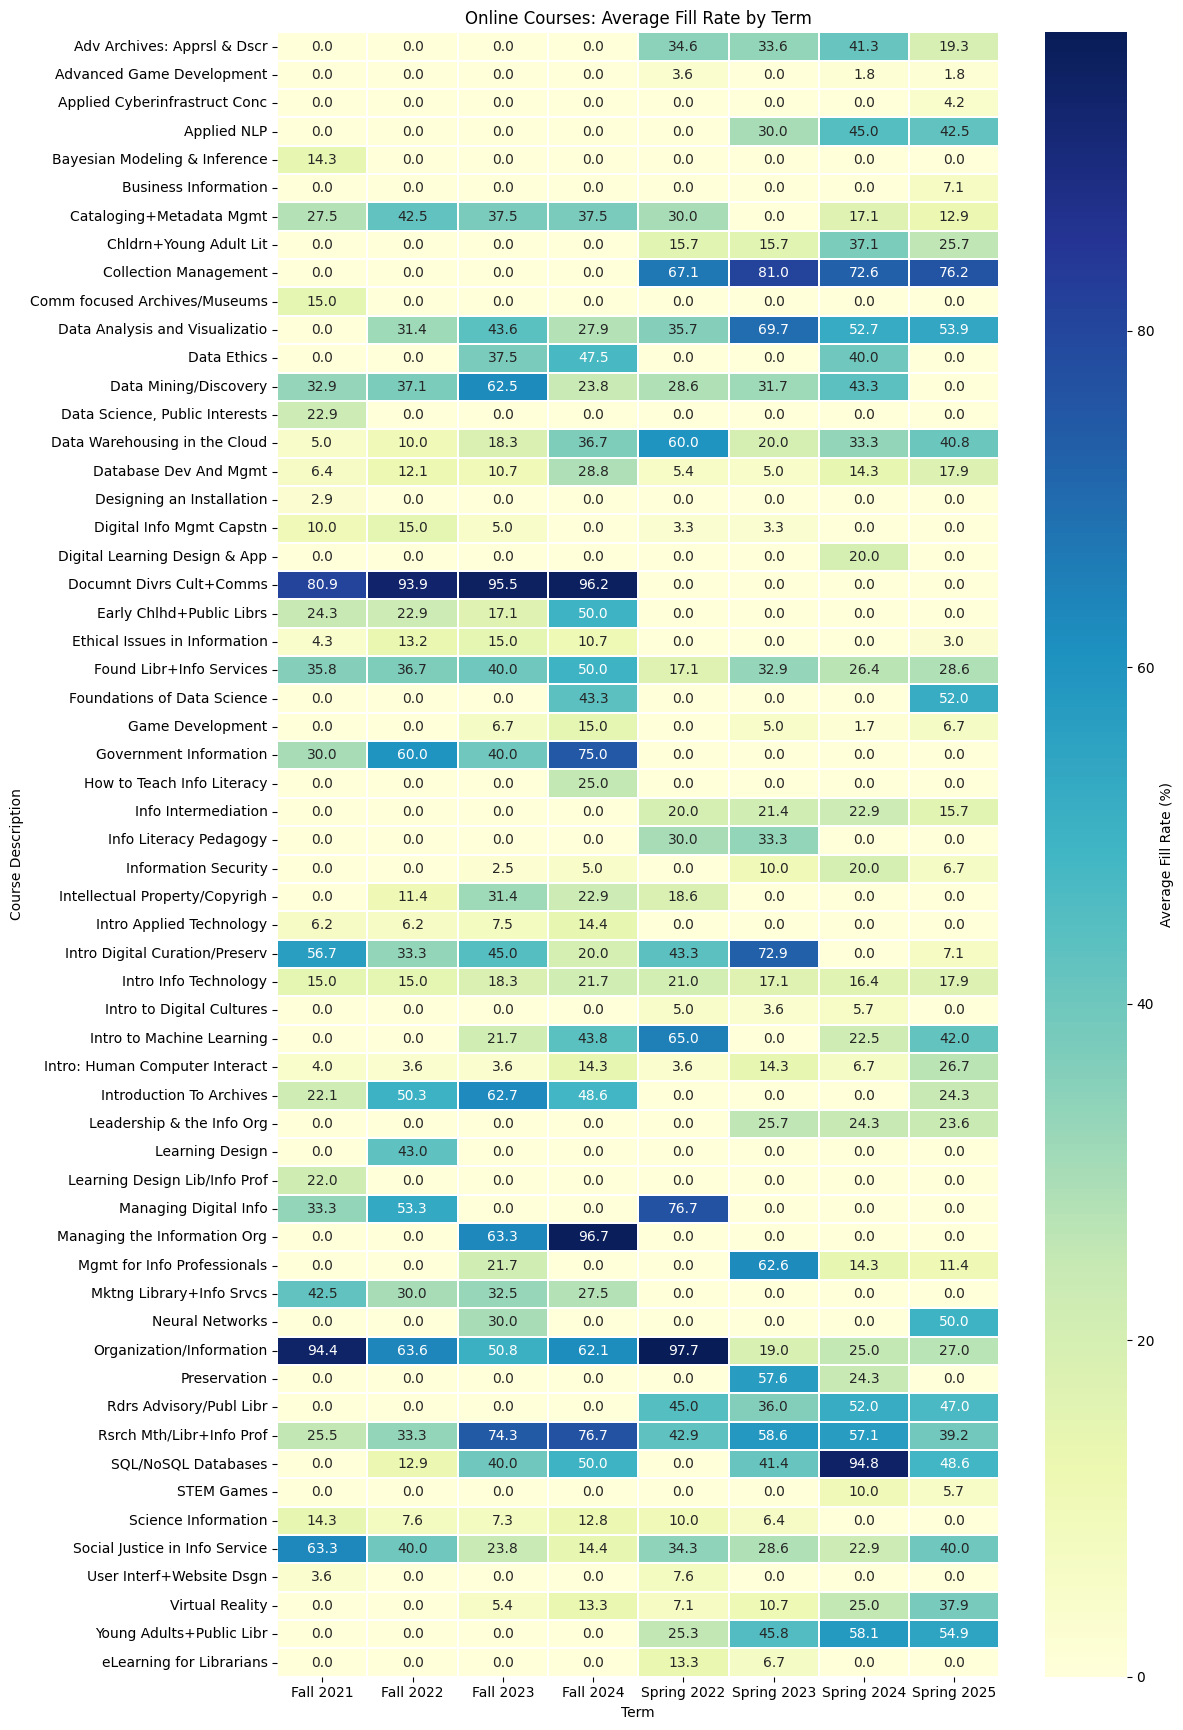

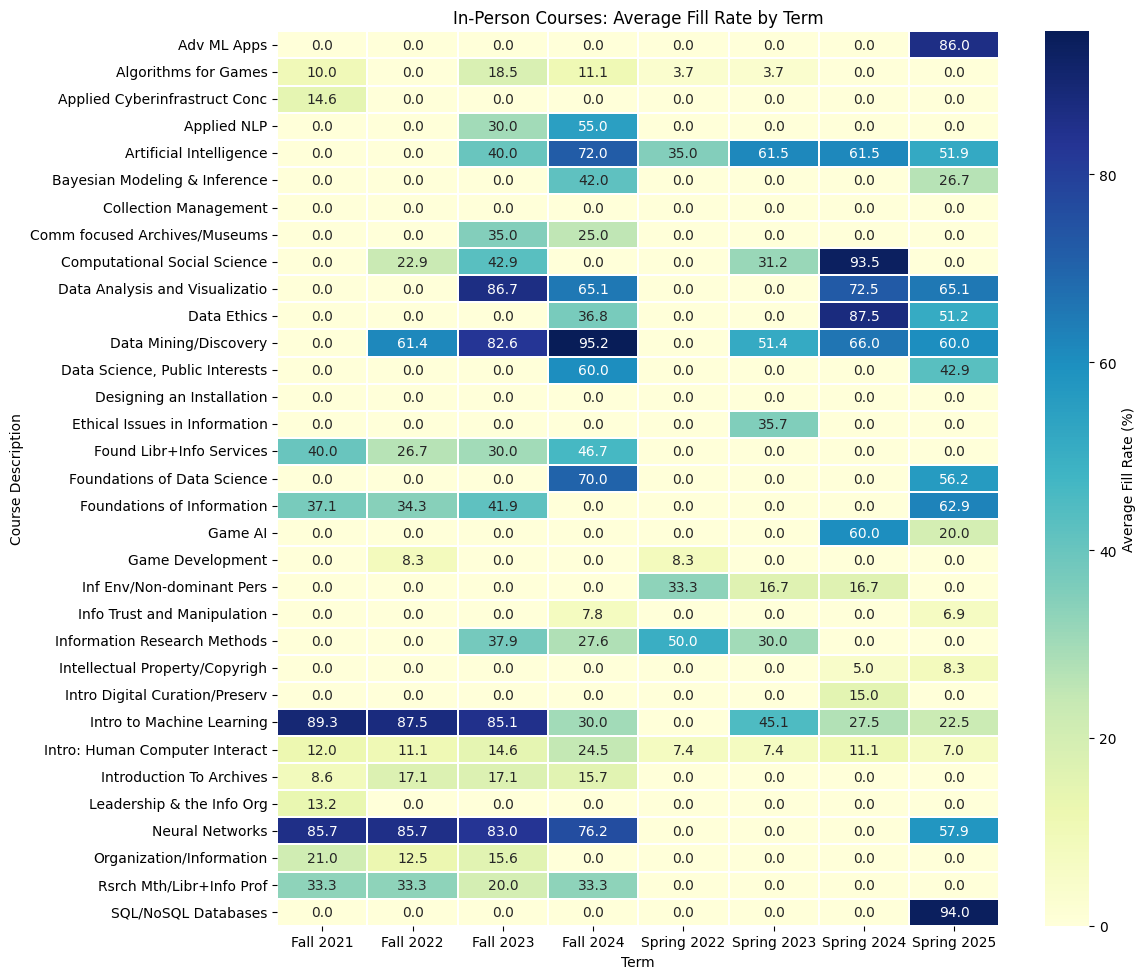

In [29]:
# Filter valid capacity
df_term_grouped = df[df['Enrollment Capacity'] > 0].copy()

# Calculate Fill Rate
df_term_grouped['Fill Rate'] = (df_term_grouped['Total Enroll'] / df_term_grouped['Enrollment Capacity']) * 100

# Separate data for Online and In-Person
df_online = df_term_grouped[df_term_grouped['Instruction Mode'].str.contains("Online", case=False, na=False)]
df_inperson = df_term_grouped[df_term_grouped['Instruction Mode'].str.strip() == "In Person"]

# Group and pivot for Online
online_avg_fill = df_online.groupby(['Course Description', 'Term'])['Fill Rate'].mean().reset_index()
pivot_online = online_avg_fill.pivot(index='Course Description', columns='Term', values='Fill Rate').fillna(0)

# Group and pivot for In-Person
inperson_avg_fill = df_inperson.groupby(['Course Description', 'Term'])['Fill Rate'].mean().reset_index()
pivot_inperson = inperson_avg_fill.pivot(index='Course Description', columns='Term', values='Fill Rate').fillna(0)

# Plot heatmap for Online
plt.figure(figsize=(12, len(pivot_online) * 0.3))
sns.heatmap(pivot_online, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.3, cbar_kws={'label': 'Average Fill Rate (%)'})
plt.title("Online Courses: Average Fill Rate by Term")
plt.xlabel("Term")
plt.ylabel("Course Description")
plt.tight_layout()
plt.show()

# Plot heatmap for In-Person
plt.figure(figsize=(12, len(pivot_inperson) * 0.3))
sns.heatmap(pivot_inperson, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.3, cbar_kws={'label': 'Average Fill Rate (%)'})
plt.title("In-Person Courses: Average Fill Rate by Term")
plt.xlabel("Term")
plt.ylabel("Course Description")
plt.tight_layout()
plt.show()


**Outcome:**  
We analyzed the **top 5 courses by average fill rate** each year from **2021 to 2025** to understand how student interest has evolved over time.

- **2021**:  
  Courses like **Intro to Machine Learning**, **Neural Networks**, and **Documenting Diverse Cultures & Communications** led with fill rates around **85–90%**, reflecting strong foundational and DEI-focused interest.

- **2022**:  
  **Documenting Diverse Cultures & Communications** continued to perform well. It was joined by **Neural Networks** and **Collection Management**, showing growing interest in both technical and library science topics.

- **2023**:  
  High engagement was seen in **project-based or applied courses** like **Managing Digital Info** and **e-Portfolio**, both averaging around **75–80% fill rates**.

- **2024**:  
  Courses such as **Managing the Information Organization**, **Documenting Diverse Cultures & Communications**, and **Data Analysis and Visualization** saw consistently high demand.

- **2025 (so far)**:  
  Technical and experiential offerings such as **Advanced ML Applications**, **Internship**, and **SQL/NoSQL Databases** topped the list with average fill rates between **70–85%**.

This trend shows that while some core courses remain popular throughout, **student interest shifts year-to-year toward practical, applied, or career-prep offerings.**


Courses like Documnt Divrs Cult+Comms, Neural Networks, and Managing the Information Org consistently attract strong enrollment.

There’s clear demand for both ML/data courses and LIS-focused electives, showing a healthy blend of tech and applied learning interests.

## Fill Rates by Course Duration (15-week vs 7-week)

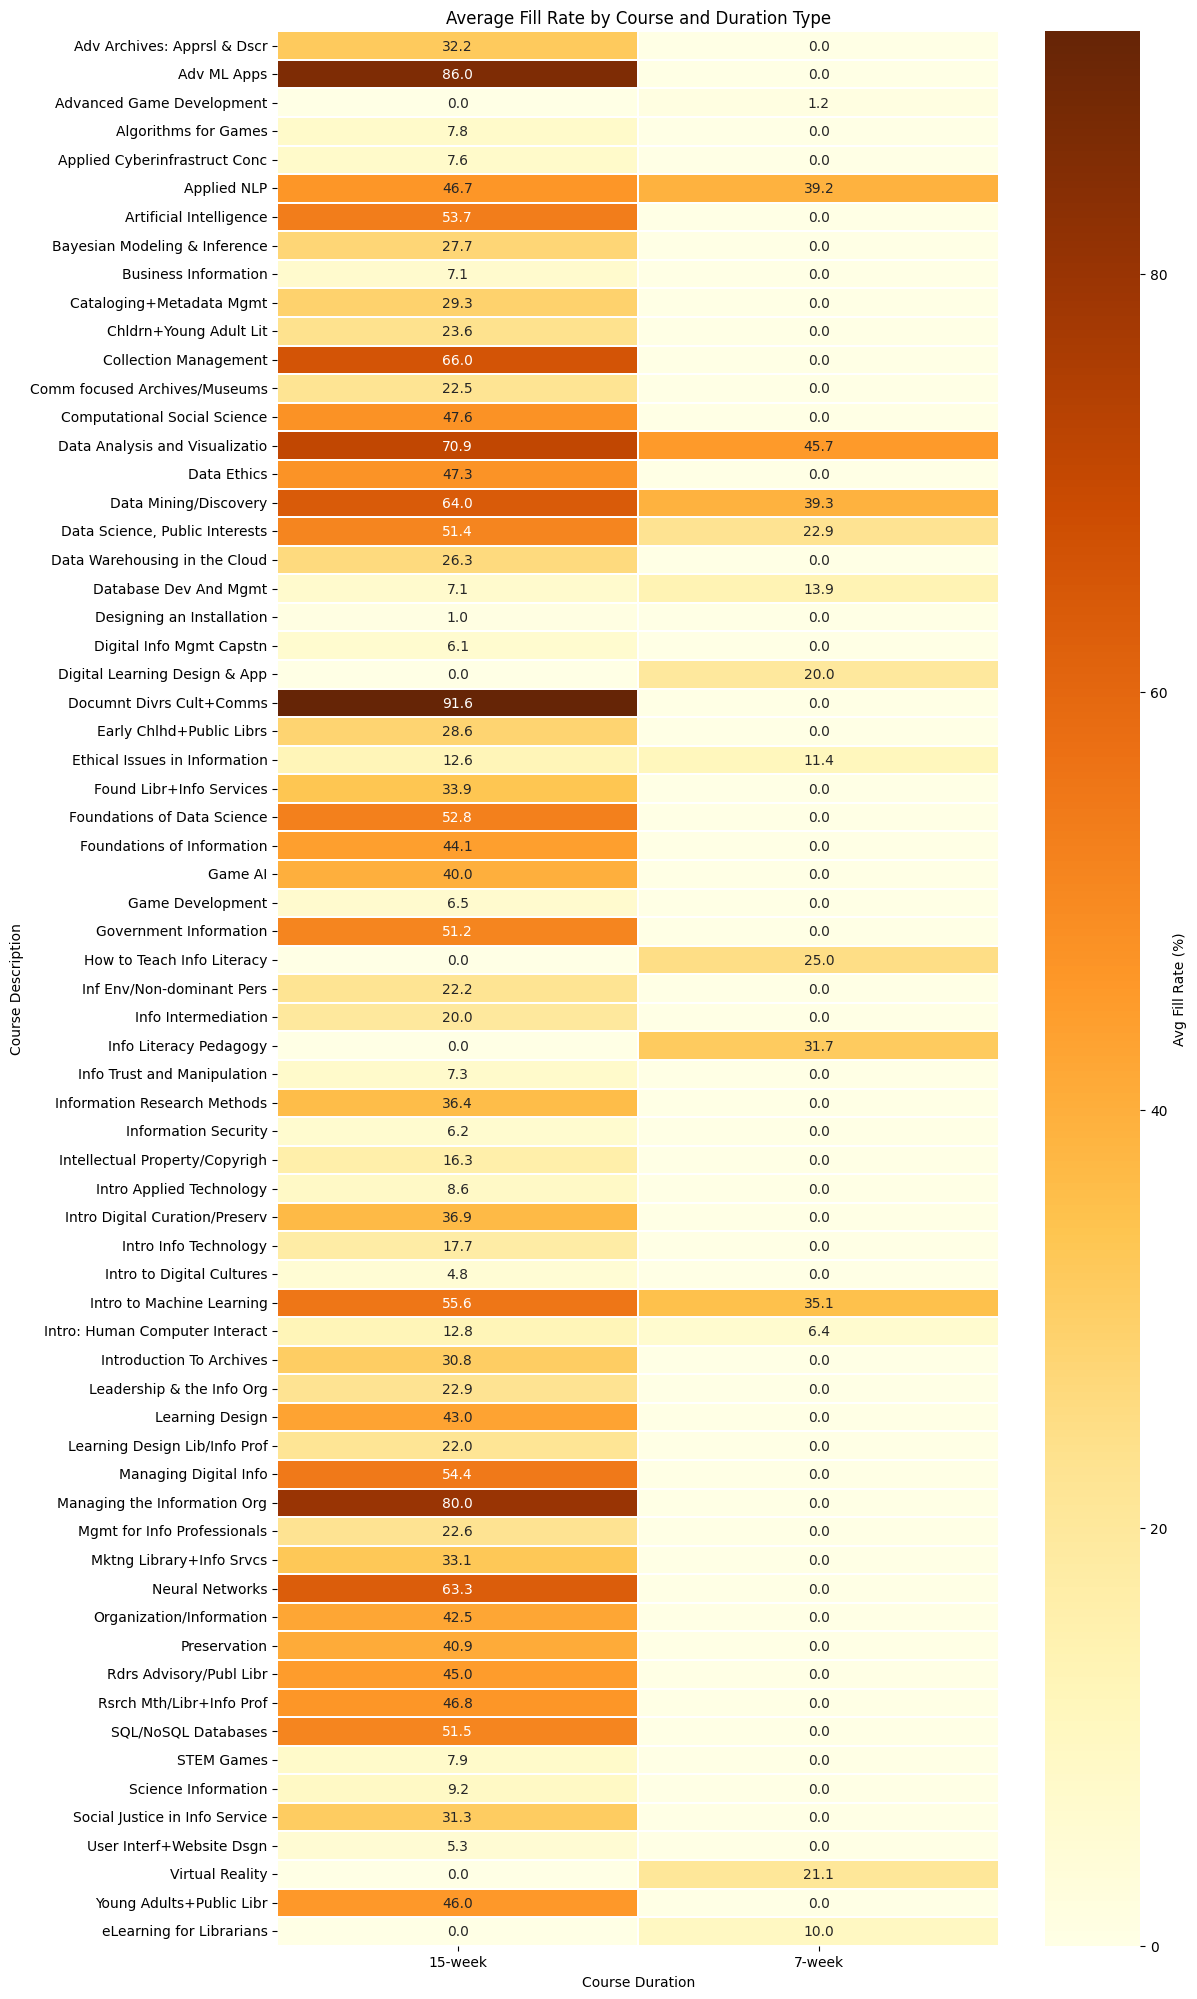

In [31]:
# Map session values to course durations
duration_map = {
    'Regular Academic Session': '15-week',
    'Seven Week - First': '7-week',
    'Seven Week - Second': '7-week'
}
df['Course Duration'] = df['Session'].map(duration_map)

# Filter only valid durations
df_duration = df[df['Course Duration'].isin(['15-week', '7-week'])].copy()

# Calculate fill rate
df_duration = df_duration[df_duration['Enrollment Capacity'] > 0]
df_duration['Fill Rate'] = (df_duration['Total Enroll'] / df_duration['Enrollment Capacity']) * 100
df_duration['Filled'] = df_duration['Fill Rate'] >= 100

# Group by Course + Duration
fill_summary = df_duration.groupby(['Course Description', 'Course Duration']).agg(
    Avg_Fill_Rate=('Fill Rate', 'mean'),
    Times_Offered=('Fill Rate', 'count'),
    Times_Full=('Filled', 'sum')
).reset_index()


durations = ['15-week', '7-week']
top_courses_by_duration = {
    dur: fill_summary[fill_summary['Course Duration'] == dur]
    .sort_values(by='Avg_Fill_Rate', ascending=False)  
    for dur in durations
}

# Pivot to format: rows = courses, columns = 15-week / 7-week
heatmap_data = fill_summary.pivot(index='Course Description', columns='Course Duration', values='Avg_Fill_Rate').fillna(0)

plt.figure(figsize=(12, len(heatmap_data) * 0.3))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrBr", linewidths=0.3, cbar_kws={'label': 'Avg Fill Rate (%)'})
plt.title("Average Fill Rate by Course and Duration Type")
plt.xlabel("Course Duration")
plt.ylabel("Course Description")
plt.tight_layout()
plt.show()

**Outcome:**  
- Shows how full each course is on average in 15-week vs. 7-week formats.

- Most courses are offered primarily in the 15-week format.

- Fill rates are generally higher in 15-week courses, indicating student preference or better planning.

- Few courses are offered as 7-week, and many have a 0% fill rate—likely not offered or under-enrolled.

- Some courses like Managing the Information Org and Rdrs Advisory/Publ Libr have decent fill rates in both formats.

## Fill Rates by School (Subject Code)

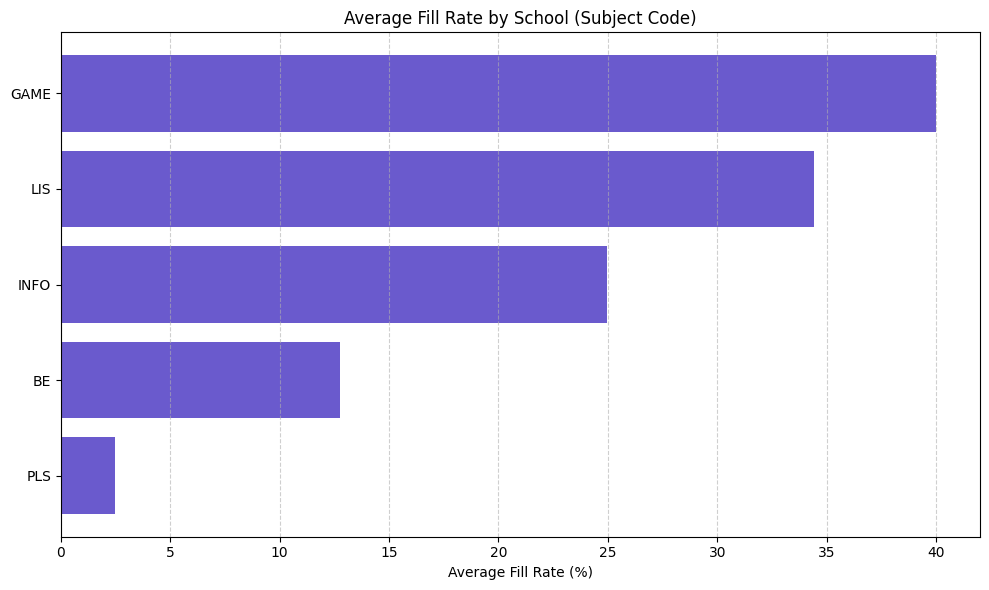

In [ ]:
# Filter valid data
df_school = df[df['Enrollment Capacity'] > 0].copy()
df_school['Fill Rate'] = (df_school['Total Enroll'] / df_school['Enrollment Capacity']) * 100
df_school['Filled'] = df_school['Fill Rate'] >= 100

# Group by Subject Code (School)
by_school = df_school.groupby('Subject Code').agg(
    Avg_Fill_Rate=('Fill Rate', 'mean'),
    Times_Offered=('Fill Rate', 'count'),
    Times_Full=('Filled', 'sum')
).reset_index().sort_values(by='Avg_Fill_Rate', ascending=False)

# Plot average fill rate by school
plt.figure(figsize=(10, 6))
plt.barh(by_school['Subject Code'], by_school['Avg_Fill_Rate'], color='slateblue')
plt.xlabel('Average Fill Rate (%)')
plt.title('Average Fill Rate by School (Subject Code)')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**Outcome:**  
This chart presents the **average fill rate by subject code**, helping to compare school-level engagement across different departments.

- **LIS (Library & Information Science)** and **INFO (Information Science)** offer the most courses and show consistently high fill rates.
  - **LIS** leads in both fill rate and number of fully enrolled courses, reflecting strong and steady student demand.
  - **INFO** also performs well, especially in **technical and data-driven offerings**.

- **BE** and **PLS** show much lower average fill rates, likely due to fewer course offerings or their status as electives rather than core program requirements.

- **GAME** technically shows the highest fill rate (~40%), but due to **very limited course offerings**, it's not considered representative and has been excluded from broader program-level comparisons.

This comparison highlights **LIS and INFO** as the most active and in-demand areas within the graduate curriculum.
